# binary igen 

In [132]:

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import sklearn
import keras
from tensorflow.keras.optimizers.legacy import Adam
from scikeras.wrappers import KerasRegressor
from keras.layers import Dropout
from keras.utils import to_categorical
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
import torch
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [133]:
def pin_update(row):
    if row["Total Row Score C"] <= 9:
        return 1
    else:
        return 0


def pin_update1(row):
     if 9 < row["Total Row Score C"]:
          return 1
     else:
          return 0 


def predic_func(pred):
    if pred[0] > pred[1]:
        return f"the estimate would be class 1 with a probability of {pred[0]*100}"
    else: 
        return f"The estimate would be class 2 with a probability of {pred[1]*100}"

In [134]:
df = pd.read_csv('Data for python.csv', sep=';', header=1, index_col=0, decimal=',')
df = df.fillna(0)
df = df.drop(columns=['Id'])
df = df.drop(columns=['ScandcleftID'])
df = df.drop(columns=['Født'])
df = df.drop(columns=['Materialedato A'])
df = df.drop(columns=['Materialedato B'])
df = df.drop(columns=['Materialedato C'])

In [135]:
Output = df.apply(pin_update, axis=1)
Output1 = df.apply(pin_update1, axis=1)
df['Output'] = Output
df['Output1'] = Output1


df1 = df[["Anteroposterior 1",
          'Anteroposterior 2',
          'Vertical 1',
          'Vertical 2',
          'Transverse',
          'Spacing',
          'Tooth shape/size\r\n',
          "Pan 2\r\n",
          'Total Row Score A',
          'Anteroposterior 1.1',
          'Anteroposterior',
          'Vertical 1.1',
          'Vertical 2.1',
          'Transverse.1',
          'Spacing.1',
          'Tooth shape/size\r\n.1',
          'Pan 2\r\n.1',
          'Total Row Score B',
          'Output',
          'Output1']]


df1 = df1.iloc[1:, :]
df1

,Anteroposterior 1,Anteroposterior 2,Vertical 1,Vertical 2,Transverse,Spacing,Tooth shape/size\r\n,Pan 2\r\n,Total Row Score A,Anteroposterior 1.1,Anteroposterior,Vertical 1.1,Vertical 2.1,Transverse.1,Spacing.1,Tooth shape/size\r\n.1,Pan 2\r\n.1,Total Row Score B,Output,Output1
Center,,,,,,,,,,,,,,,,,,,,
H,9.0,0.0,0.0,0.0,6.0,4.0,0.0,4.0,23,0.0,0.0,0.0,0.0,6.0,4.0,0.0,3.0,13,1,0
H,9.0,0.0,0.0,0.0,6.0,1.0,1.0,3.0,21,9.0,0.0,2.0,4.0,6.0,0.0,1.0,3.0,25,1,0
H,0.0,0.0,0.0,0.0,2.0,1.0,0.0,4.0,10,0.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0,10,1,0
H,9.0,0.0,1.0,0.0,6.0,0.0,1.0,4.0,25,9.0,0.0,2.0,0.0,6.0,0.0,1.0,4.0,26,1,0
H,0.0,0.0,0.0,0.0,6.0,0.0,0.0,4.0,10,0.0,0.0,0.0,0.0,2.0,4.0,0.0,3.0,9,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Å,9.0,0.0,1.0,0.0,6.0,3.0,0.0,4.0,23,9.0,0.0,0.0,0.0,6.0,3.0,0.0,3.0,21,1,0
Å,9.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,21,12.0,0.0,3.0,4.0,6.0,0.0,0.0,3.0,32,1,0
Å,12.0,0.0,0.0,0.0,6.0,0.0,0.0,4.0,25,9.0,0.0,0.0,0.0,6.0,0.0,0.0,4.0,23,0,1


In [136]:
#sletter output1 skal bare sættes ind igen

target_column = ["Output","Output1"]
numerical_column = df1.columns.drop(target_column)
output_rows = df1[target_column]
df1.drop(target_column,axis=1,inplace=True)


In [137]:
df_syn = pd.read_csv('synthetic_data.csv')
Output = df_syn.apply(pin_update, axis=1)
Output1 = df_syn.apply(pin_update1, axis=1)
#Output2 = df_syn.apply(pin_update2, axis=1)
df_syn['Output'] = Output
df_syn['Output1'] = Output1
#df_syn['Output2']  = Output2
df_syn
df1_syn = df_syn[["Anteroposterior 1",
          'Anteroposterior 2',
          'Vertical 1',
          'Vertical 2',
          'Transverse',
          'Spacing',
          'Tooth shape/size\r\n',
          "Pan 2\r\n",
          'Total Row Score A',
          'Anteroposterior 1.1',
          'Anteroposterior',
          'Vertical 1.1',
          'Vertical 2.1',
          'Transverse.1',
          'Spacing.1',
          'Tooth shape/size\r\n.1',
          'Pan 2\r\n.1',
          'Total Row Score B',
          'Output',
          'Output1']]
df1_syn.iloc[1:, :]

target_column = ["Output","Output1"]
numerical_column = df1_syn.columns.drop(target_column)
output_rows_syn = df1_syn[target_column]
df1_syn.drop(target_column,axis=1,inplace=True)

scaler = MinMaxScaler()
scaler.fit(df1_syn)
df1_syn = scaler.transform(df1_syn)


X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(df1_syn, output_rows_syn, test_size=0.25,shuffle=True)

/var/folders/d5/qsvd0xbs3610vyxc_s5y8cv80000gn/T/ipykernel_2076/2591370598.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_syn.drop(target_column,axis=1,inplace=True)


In [138]:
X_train, X_test, y_train, y_test = train_test_split(df1, output_rows, test_size=0.25,shuffle=True)

inputs = np.concatenate((X_train_syn, X_test_syn), axis=0)
targets = np.concatenate((y_train_syn, y_test_syn), axis=0)

kfold = KFold(n_splits=num_folds, shuffle=True)

In [139]:
no_classes = 3
no_epochs = 10
optimizer = Adam()
verbosity = 1
num_folds = 5
batch_size = 64
acc_per_fold = []
loss_per_fold = []
fold_no = 1

In [140]:
for train, test in kfold.split(inputs, targets):
    model = Sequential()
    
    model.add(Dense(128, input_dim=18, activation='relu'))

    model.add(Dense(64,activation='relu'))

    model.add(Dense(32,activation='relu'))
 
    model.add(Dense(16,activation='relu'))

    model.add(Dense(8,activation='relu'))

    model.add(Dense(2, activation='softmax'))

 # Compile model
    model.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

     # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
  # Fit data to model
    history = model.fit(inputs[train], targets[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity)

  # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] *100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1
    
fold_no = 1 

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10


223/223 [==============================] - 11s 21ms/step - loss: 0.4660 - accuracy: 0.8335
Epoch 2/10
223/223 [==============================] - 3s 12ms/step - loss: 0.4481 - accuracy: 0.8376
Epoch 3/10
223/223 [==============================] - 3s 12ms/step - loss: 0.4995 - accuracy: 0.8377
Epoch 4/10
223/223 [==============================] - 3s 12ms/step - loss: 0.4613 - accuracy: 0.8375
Epoch 5/10
223/223 [==============================] - 3s 13ms/step - loss: 0.4428 - accuracy: 0.8375
Epoch 6/10
223/223 [==============================] - 3s 13ms/step - loss: 0.4427 - accuracy: 0.8376
Epoch 7/10
223/223 [==============================] - 3s 13ms/step - loss: 0.4420 - accuracy: 0.8376
Epoch 8/10
223/223 [==============================] - 3s 12ms/step - loss: 0.4472 - accuracy: 0.8375
Epoch 9/10
223/223 [==============================] - 3s 12ms/step - loss: 0.4467 - accuracy: 0.8375
Epoch 10/10
223/223 [==============================] - 3s 12ms/step - loss: 0.4431 - accuracy: 0.8376

4/4 [==============================] - 1s 23ms/step


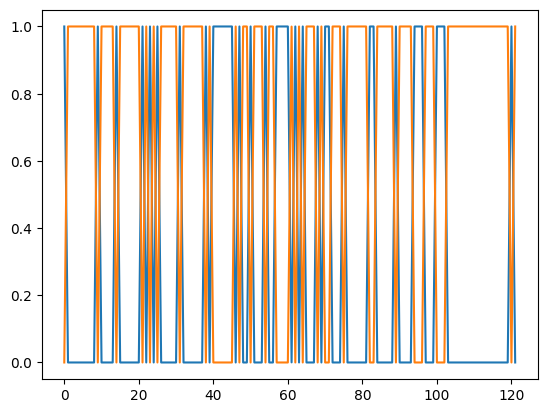

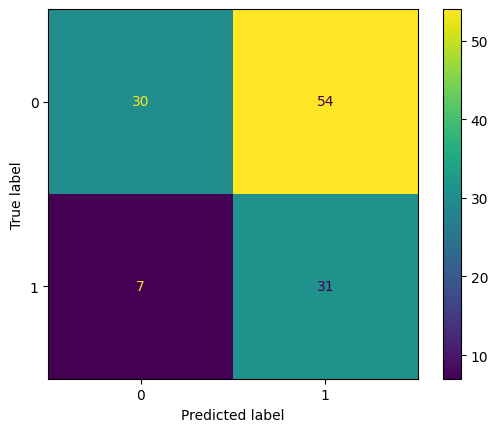

In [141]:
predicted = model.predict(df1)
tensor = torch.tensor(output_rows.values)
predic = tf.squeeze(predicted)


plt.plot(predic)

predict= np.array([np.argmax(row) for row in predic])
actual = np.array([np.argmax(row) for row in tensor])
conf_mat = confusion_matrix(actual, predict)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

In [142]:
def total_row_score(vector):
    vector[8] = sum(vector[0:8])
    vector[17] = sum(vector[9:17])
    print(vector)

In [145]:

xnew = np.array([12, 0, 3, 0, 6, 0, 4 ,4, 0,
                 12, 0, 2, 3, 8, 0, 4, 3, 0])

total_row_score(xnew)

new_prediction = model.predict(xnew.reshape(1,18))
new_prediction = tf.squeeze(new_prediction)

print(new_prediction)

[12  0  3  0  6  0  4  4 29 12  0  2  3  8  0  4  3 32]
1/1 [==============================] - 0s 28ms/step
tf.Tensor([0. 1.], shape=(2,), dtype=float32)


In [144]:
predic_func(new_prediction)

'the estimate would be class 1 with a probability of 100.0'